# Very simple Normalizing Flows in Torch

## Target distribution to sample from

We will sample from a mixture of 2D Gaussians. The target distribution is defined as follows:

$$
p(x_1, x_2) = N(x_1|\frac{1}{4x_2^2}, 1) \cdot N(x_2|0,1)
$$

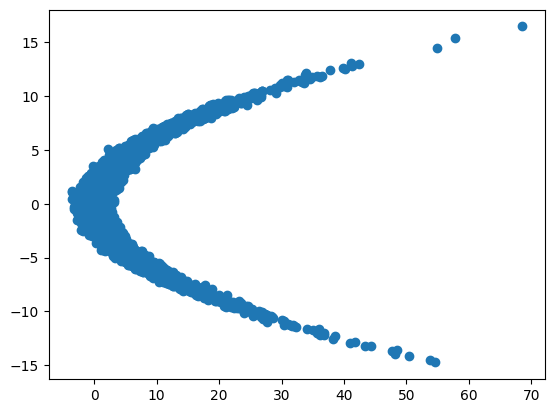

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# modelling multivariate normal distribution
# samples from target distribution:
# p(x1, x2) = N(x_1|1/4x_2^2, 1)*N(x_2|0, 4)

x2_dist = torch.distributions.Normal(0, 4)
x2_samples = x2_dist.sample((10000,))
x1_dist = torch.distributions.Normal(0.25*x2_samples**2, 1)
x1_samples = x1_dist.sample()

plt.scatter(x1_samples, x2_samples)

target_samples = torch.stack([x1_samples, x2_samples], dim=1)

In [17]:
# base dist (multivariate normal diagonal)
base_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [18]:
leaky_relu = torch.nn.LeakyReLU(negative_slope=0.01)

Epoch 0, loss: 18.802762985229492
Epoch 100, loss: -529.6129760742188


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

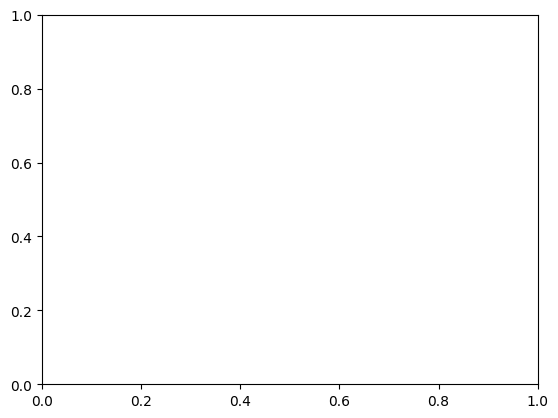

In [84]:
# normalizing flow model, LeakyReLU activation, 4 layers, affine shift

class NormalizingFlow(torch.nn.Module):
    def __init__(self, n_layers, n_features):
        super(NormalizingFlow, self).__init__()
        self.n_layers = n_layers
        self.n_features = n_features
        self.flow = torch.nn.ModuleList()
        for i in range(n_layers):
            self.flow.append(torch.nn.Sequential(
                torch.nn.Linear(n_features, n_features),
                torch.nn.LeakyReLU(negative_slope=0.01),
                torch.nn.Linear(n_features, n_features)
            ))
    def forward(self, x):
        for i in range(self.n_layers):
            x = x + self.flow[i](x)
        return x
    
    def inverse(self, y):
        for i in range(self.n_layers):
            y = y - self.flow[self.n_layers - i - 1](y)
        return y
    
    def log_det_jacobian(self, x):
        ldj = 0
        for i in range(self.n_layers):
            ldj += torch.sum(leaky_relu(self.flow[i][0](x)), dim=1)
        return ldj
    
    def sample(self, n_samples):
        z = base_dist.sample((n_samples,))
        x = self.inverse(z)
        return x
    
    
n_layers = 4
n_features = 2

flow = NormalizingFlow(n_layers, n_features)

# training
n_epochs = 200
batch_size = 100
n_batches = target_samples.shape[0] // batch_size
optimizer = torch.optim.Adam(flow.parameters(), lr=0.001)

for epoch in range(n_epochs):
    for i in range(n_batches):
        optimizer.zero_grad()
        x = target_samples[i*batch_size:(i+1)*batch_size]
        z = flow(x)
        loss = -torch.mean(base_dist.log_prob(z) + flow.log_det_jacobian(x))
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, loss: {loss.item()}')



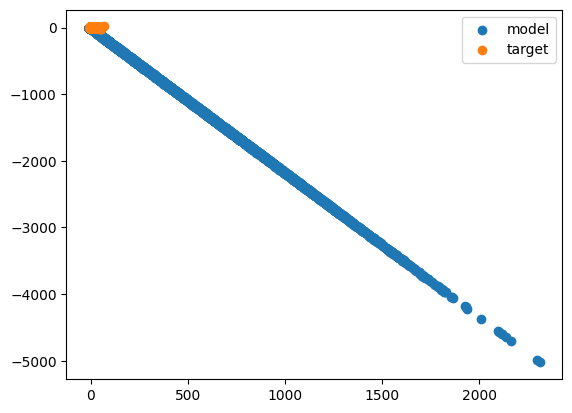

In [85]:
# sampling from the model
samples = flow.sample(10000)

plt.figure()
plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], label='model')
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='target')
plt.legend()
plt.show()